# ATG Data Scientist Challenge

Thank you for your interest in joining the data science team at Uber ATG. The next step is to complete Uber ATG’s take home exercise. This will allow you to get an idea of what it's like to work for us while showcasing your statistics, programming, and data analysis capabilities.

While we invite you to fill out the remainder of this notebook for your submission, you may send your results back in any format as long as the work/code/analysis is reproducible. We've had candidates submit RMarkdown HTMLs or LaTeX generated PDFs as well. You may use any language (or Jupyter Kernel) you want but keep in mind that we primarily do deployment, engineering, and analysis work in Python.

There is no time limit, but please try to send back the completed assignment within 1 week of receiving it. Please delete any data you have downloaded from us after submitting the assignment.

If you have any questions about the assignment, please reach out to your recruiter.

Thanks, ATG Data Science

# Driver Signup Analysis

You can use the csv:

* ds_challenge_v2_data.csv

included in the zip file included with this notebook.

Uber’s Driver team is interested in predicting which driver signups are most likely to start driving. To help explore this question, we have provided a sample dataset of a cohort of driver signups in January 2015. The data was pulled a few months after they signed up to include the result of whether they actually completed their first trip. It also includes several pieces of background information gathered about the driver and their car.

See below for a detailed description of the dataset:

* **id**: driver_id
* **city_id**: city_id this user signed up in
* **signup_os**: signup device of the user (“android”, “ios”, “website”, “other”)
* **signup_channel**: what channel did the driver sign up from (“offline”, “paid”, “organic”, “referral”)
* **signup_timestamp**: timestamp of account creation; local time in the form ‘YYYY-MM-DD’
* **bgc_date**: date of background check consent; in the form ‘YYYY-MM-DD’
* **vehicle_added_date**: date when driver’s vehicle information was uploaded (by the driver); in the form ‘YYYY-MM-DD’
* **first_trip_date**: date of the first trip as a driver; in the form ‘YYYY-MM-DD’
* **vehicle_make**: make of vehicle uploaded (i.e. Honda, Toyota)
* **vehicle_model**: model of vehicle uploaded (i.e. Accord, Prius, 350z)
* **vehicle_year**: year that the car was made; in the form ‘YYYY’

Our primary goal is to understand what factors are best at predicting whether a signup will start to drive, and offer suggestions to operationalize those insights to help Uber. This take home consists of answering three main tasks with some discussion questions under them to get you started.

Ordering and presentation format is up to you, but we love analyses that are well organized and have a linear flow from data ingestion to final result(s). We especially look for well stated assumptions and an eye for business/product impact of any analysis or model:

#### Note: This take home challenge is finished with Anaconda conda 4.5.1 with Python 3.6.3 :: Anaconda custom (64-bit).

# Section I

## **Conduct an exploratory analysis of the data to give us qualitative and quantitative insights.**
  * Does all the data make sense? Did you have to throw anything away? Are there interesting patterns that emerge?

### Exploratory analysis

  1. There is no duplicated records
  2. There is missing data issue.
     * signup_os, 6857. We treat this missing type as an important type itself. 
     * bgc_date, 21938. We assume this missing is becuase they never had their background check done yet.
     * vehicle_added_date, 41547. We assume this missing is becuase they never added a vehicle.
     * vehicle_make, 41458. We assume this missing is becuase they never added a vehicle.
     * vehicle_model, 41458. We assume this missing is becuase they never added a vehicle.
     * vehicle_year, 41458. We assume this missing is becuase they never added a vehicle.
     * first_completed_date, 48544. We assume this missing is becuase they never completed a ride yet.
  3. There are three different cities. **Strark** has 54% signups, **Berton** has 37% signups and **Wrouver** has 9% singups.
  4. The overall signups has completed one ride is 11.2%. The three cities are a little bit different from each other.
  5. **Paid** signup channel has the lowest rate to complete first drive and **Referral** has the highest rate to complete first drive.
  6. For signup_os, **mac** has the highest rate to complete first drive, and **NA** has the lowest rate to complete first drive.
  7. We treat signups on different days equally.
    * The longest day between signup and completed date is 30 day.
      * Assumption: we do not consider these who makes a first drive after 30 days of signup. 
    * There is no difference between signup_date 1/1/2016 and 1/31/2016.
      * Assumption: we treat signups on different days equally.
  8. Possibly due to 'cliff' effect in dataset, i.e. the longest days between signup_to_completed is 30 days.
    * 2212 records have signup_to_added days larger than 30; 6 have completed first drive among them.
    * 1960 records have signup_to_bgc days larger than 30; 5 have completed first drive among them.
  9. **vehicle_make** and **vehicle_model** do not have any pattern, so we do not consider them as of now. If we want to consider what kind of drive, such as Uber Pool or Uber X, these information can be very useful.
  10. Other data issues:
      * There is two records with vehicle_make is 'Bike', 'Bicycle'.
  
#### Remark:
The biggest issue here is that the last first_completed_date is 2/29/2016, however there is bgc_date and vehecle_added_date later than 2/29/2016. This is definitely a **"cliff"** effect in the dataset. As a critial step to minimize this **"cliff"** effect, we remove the records that have bgc_date - signup_date larger than 30 and vehicle_added_date - signup_date larger than 30.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re, math
%matplotlib inline

In [2]:
# Read in dataset

df = pd.read_csv('ds_challenge_v2_data.csv')
for i in ['signup_date', 'bgc_date', 'vehicle_added_date', 'first_completed_date']:
    df[i] = pd.to_datetime(df[i], infer_datetime_format=True)

In [3]:
df.head()

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,1,Strark,ios web,Paid,2016-01-02,NaT,NaT,NaN,NaN,NaN,NaT
1,2,Strark,windows,Paid,2016-01-21,NaT,NaT,NaN,NaN,NaN,NaT
2,3,Wrouver,windows,Organic,2016-01-11,2016-01-11,NaT,NaN,NaN,NaN,NaT
3,4,Berton,android web,Referral,2016-01-29,2016-02-03,2016-02-03,Toyota,Corolla,2016.0,2016-02-03
4,5,Strark,android web,Referral,2016-01-10,2016-01-25,2016-01-26,Hyundai,Sonata,2016.0,NaT


In [4]:
# Check total record number

total_records = len(df)
print('Total number of records: %d.'%len(df))
print('Unique id: %d.'%(len(df.id.unique().tolist())))

Total number of records: 54681.
Unique id: 54681.


In [5]:
# Check duplicated data

df.duplicated().sum()

0

In [6]:
# Check missing data

df.isnull().sum()

id                          0
city_name                   0
signup_os                6857
signup_channel              0
signup_date                 0
bgc_date                21938
vehicle_added_date      41547
vehicle_make            41458
vehicle_model           41458
vehicle_year            41458
first_completed_date    48544
dtype: int64

In [7]:
df.dtypes

id                               int64
city_name                       object
signup_os                       object
signup_channel                  object
signup_date             datetime64[ns]
bgc_date                datetime64[ns]
vehicle_added_date      datetime64[ns]
vehicle_make                    object
vehicle_model                   object
vehicle_year                   float64
first_completed_date    datetime64[ns]
dtype: object

In [8]:
# Check some features

print('City names:')
print(df.city_name.unique().tolist())
print('Signup OS :')
print(df.signup_os.unique().tolist())
print('Signup Channel:')
print(df.signup_channel.unique().tolist())
# print('Vehicle Make:') 
# print(df.vehicle_make.unique().tolist())
# print('Vehicle Model:')
# print(df.vehicle_model.unique().tolist())
# print('Vehicle Year:')
# print(df.vehicle_year.unique().tolist())

City names:
['Strark', 'Wrouver', 'Berton']
Signup OS :
['ios web', 'windows', 'android web', nan, 'mac', 'other']
Signup Channel:
['Paid', 'Organic', 'Referral']


In [9]:
# Finished first drive percent.

print('Total number with first completed date: %.3f'%(df.first_completed_date.notnull().sum() / len(df)))

Total number with first completed date: 0.112


In [10]:
# Signup per city

cities = df.city_name.unique().tolist()

for i in cities:
    print('For %s signup is %d and finished percent %.4f.'%
          (i, len(df[df.city_name == i]), len(df[df.city_name == i]) / len(df)))
    print('Completed first is %d and percent %.4f.'%(df[df.city_name == i].first_completed_date.notnull().sum(), 
                        df[df.city_name == i].first_completed_date.notnull().sum() / len(df[df.city_name == i])))

For Strark signup is 29557 and finished percent 0.5405.
Completed first is 3239 and percent 0.1096.
For Wrouver signup is 5007 and finished percent 0.0916.
Completed first is 461 and percent 0.0921.
For Berton signup is 20117 and finished percent 0.3679.
Completed first is 2437 and percent 0.1211.


In [11]:
# For those with vehicle added and finished first drive.

added_completed = len(df[(df.vehicle_added_date.notnull()) & (df.first_completed_date.notnull())])
added_not_completed = len(df[(df.vehicle_added_date.notnull()) & (df.first_completed_date.isnull())])
completed = len(df[df.first_completed_date.notnull()])

print('%d added vehicle'%(added_completed + added_not_completed))
print('%d completed first drive.'%(completed))
print('%d Added vehicle and completed first is %.3f of total completed.'%
      (added_completed, added_completed / completed))
print('%d Added vehicle and not completed first number.'%(added_not_completed))

13134 added vehicle
6137 completed first drive.
5872 Added vehicle and completed first is 0.957 of total completed.
7262 Added vehicle and not completed first number.


In [12]:
# To see whether there is any difference between signup_os.

signup_OSs = ['ios web', 'windows', 'android web', 'mac', 'other']
for i in signup_OSs:
    t_tot = len(df[df.signup_os == i])
    t_num = len(df[(df.signup_os == i) & (df.first_completed_date.notnull())])
    print('For %12s, %6d signups and %8.3f completed first drive.'
          %(i, t_tot, t_num / t_tot))

t_tot = len(df[df.signup_os.isnull()])
t_num = len(df[(df.signup_os.isnull()) & (df.first_completed_date.notnull())])
print('For           NA, %6d signups and %8.3f completed first drive.'
          %(t_tot, t_num / t_tot))

For      ios web,  16632 signups and    0.132 completed first drive.
For      windows,   6776 signups and    0.133 completed first drive.
For  android web,  14944 signups and    0.097 completed first drive.
For          mac,   5824 signups and    0.163 completed first drive.
For        other,   3648 signups and    0.137 completed first drive.
For           NA,   6857 signups and    0.022 completed first drive.


In [13]:
# To see whether there is any difference between signup_channel.

signup_channels = ['Paid', 'Organic', 'Referral']
for i in signup_channels:
    t_tot = len(df[df.signup_channel == i])
    t_num = len(df[(df.signup_channel == i) & (df.first_completed_date.notnull())])
    print('For %s signup channel, there are %d signups and %.3f completed first drive.'
          %(i, t_tot, t_num / t_tot))

For Paid signup channel, there are 23938 signups and 0.062 completed first drive.
For Organic signup channel, there are 13427 signups and 0.090 completed first drive.
For Referral signup channel, there are 17316 signups and 0.199 completed first drive.


### Visualization and Exploration

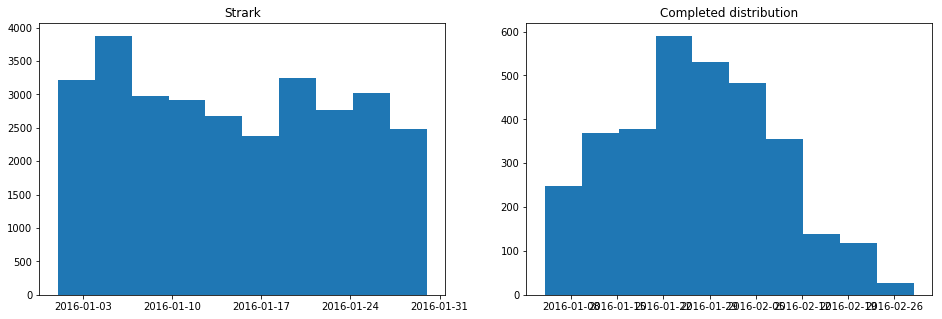

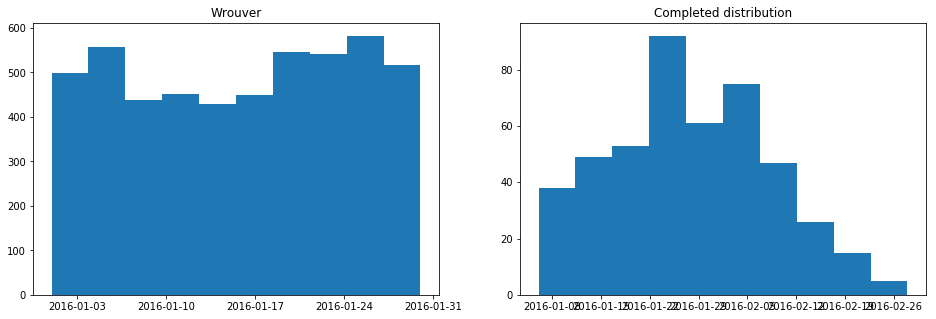

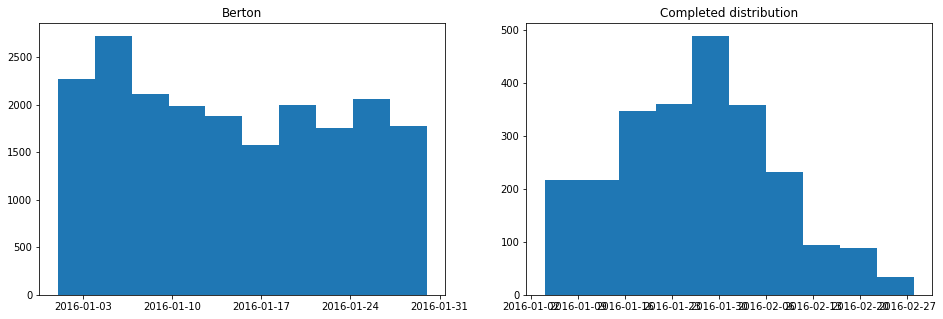

In [14]:
# Date Distribution of Signup and first_completed_date by cities.

for i in cities:
    fig = plt.figure(figsize=(16, 5))
    ax1 = fig.add_subplot(121)
    ax1.hist(df[df.city_name == i].signup_date)
    ax1.set_title(i)
    
    ax2 = fig.add_subplot(122)
    ax2.hist(df[(df.city_name == i) & (df.first_completed_date.notnull())].first_completed_date)
    ax2.set_title('Completed distribution')
    
    plt.show()

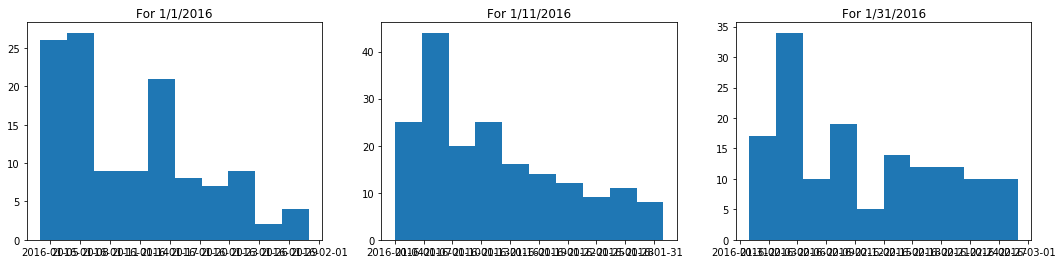

In [15]:
# Check whether there is any "cliff" effect in the dataset.
# The first signup_date in dataset is 1/1/2016.
# The last first_completed_date is 2/29/2016.
# The maxium time between signup and first_completed_date is 30 days.
# There is no obvious difference between signup cohort 1/1/2016, 1/11/2016 and 1/31/2016.

fig = plt.figure(figsize=(18, 4))
ax1 = fig.add_subplot(131)
ax1.hist(df[(df.signup_date == '2016-01-01T00:00:00.000000000') 
            & (df.first_completed_date.notnull())].first_completed_date)
ax1.set_title('For 1/1/2016')

ax2 = fig.add_subplot(132)
ax2.hist(df[(df.signup_date == '2016-01-02T00:00:00.000000000') 
            & (df.first_completed_date.notnull())].first_completed_date)
ax2.set_title('For 1/11/2016')

ax3 = fig.add_subplot(133)
ax3.hist(df[(df.signup_date == '2016-01-30T00:00:00.000000000') 
            & (df.first_completed_date.notnull())].first_completed_date)
ax3.set_title('For 1/31/2016')

plt.show()

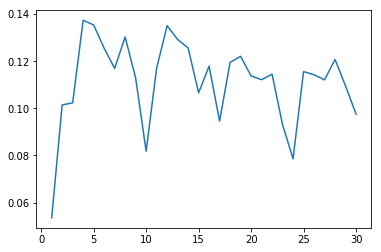

In [16]:
# Treat signups on one day as one group
# View the first drive complete by these groups.
# There is some different between signups during weekend and weekday.

dates = df.signup_date.unique()
completed_by_date = []
for i in dates:
    t_num = len(df[(df.signup_date == i) & (df.first_completed_date.notnull())])
    t_total = len(df[df.signup_date == i])
    completed_by_date.append({'date':i, 'percent':t_num / t_total})
df_completed_by_date = pd.DataFrame(completed_by_date)
df_completed_by_date['day'] = df_completed_by_date.date.dt.day
df_completed_by_date.sort_values(by=['day'], ascending=True, inplace=True)
plt.plot(df_completed_by_date.day, df_completed_by_date.percent)
plt.show()

### Feature Engineering

In [17]:
# Create dependent variable

df = df.assign(label=df['first_completed_date'].notnull())
df['label'] = df['label'].map(lambda x: 1 if x else 0)

In [18]:
# Create dummy variables.

df = df.join(pd.get_dummies(df.signup_os))
df = df.join(pd.get_dummies(df.signup_channel))
df.rename(columns={'android web':'android', 'ios web':'ios'}, inplace=True)

In [19]:
# We see some pattern for signup_date by date and completed first drive.
# Create a variable to indicate whether it is a weekend.

def is_weekend(x):
    if x in [5,6,0]:
        return 1
    else:
        return 0
    
df['is_weekend'] = df.signup_date.dt.weekday.map(lambda x: is_weekend(x))

In [20]:
# Create dummy variable to indicate whether the drive has bgc_date or vehicle_added_date

df = df.assign(has_bgc=df['bgc_date'].notnull())
df = df.assign(has_vehicle=df['vehicle_added_date'].notnull())

In [21]:
# Create a variable to describe how old the vehicle is

df['vehicle'] = df['vehicle_year'].map(lambda x: 2017 - x)

In [22]:
# Feature engineering to add variables to measure the day differences.

df['signup_to_completed'] = df['first_completed_date'] - df['signup_date']
df['signup_to_completed'] = df['signup_to_completed'].dt.days

df['added_to_completed'] = df['first_completed_date'] - df['vehicle_added_date']
df['added_to_completed'] = df['added_to_completed'].dt.days

df['signup_to_bgc'] = df['bgc_date'] - df['signup_date']
df['signup_to_bgc'] = df['signup_to_bgc'].dt.days

df['signup_to_added'] = df['vehicle_added_date'] - df['signup_date']
df['signup_to_added'] = df['signup_to_added'].dt.days

df['bgc_to_added'] = df['vehicle_added_date'] - df['bgc_date']
df['bgc_to_added'] = df['bgc_to_added'].dt.days

In [23]:
# Variables to be included in the model

features_base = ['android', 'ios', 'mac', 'other', 'windows', 'Organic', 
            'Paid', 'Referral', 'has_bgc', 'has_vehicle']

features = ['android', 'ios', 'mac', 'other', 'windows', 'Organic',
            'Paid', 'Referral', 'vehicle', 'signup_to_bgc', 'signup_to_added', 
            'bgc_to_added', 'has_bgc', 'has_vehicle', 'is_weekend']

features_less = ['android', 'ios', 'mac', 'other', 'windows', 
            'Paid', 'Referral', 'vehicle', 'signup_to_bgc', 'signup_to_added', 
            'bgc_to_added', 'has_bgc', 'has_vehicle', 'is_weekend']

In [24]:
# Get dataset for modeling

df_model = df[['label', 'city_name'] + features]

In [25]:
# "Cliff" effect.

print('%5d have signup_to_added days larger than 30.'%df[df['signup_to_added'] > 30]['label'].count())
print('%5d have completed first drive among them.'%df[df['signup_to_added'] > 30]['label'].sum())
print('%5d have signup_to_bgc days larger than 30.'%df[df['signup_to_bgc'] > 30]['label'].count())
print('%5d have completed first drive among them.'%df[df['signup_to_bgc'] > 30]['label'].sum())

 2212 have signup_to_added days larger than 30.
    6 have completed first drive among them.
 1960 have signup_to_bgc days larger than 30.
    5 have completed first drive among them.


Added to complete first drive median days: 4


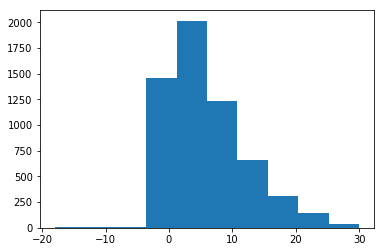

In [26]:
print('Added to complete first drive median days: %d'%
      df[df['added_to_completed'].notnull()]['added_to_completed'].median())
counts, bins, fig = plt.hist(df[df['added_to_completed'].notnull()]['added_to_completed'])
plt.show()

Signup to added vehicle median days: 11


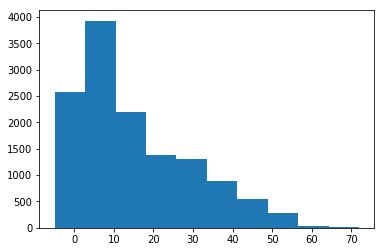

In [27]:
print('Signup to added vehicle median days: %d'%
      df[df['signup_to_added'].notnull()]['signup_to_added'].median())
counts, bins, fig = plt.hist(df[df['signup_to_added'].notnull()]['signup_to_added'])
plt.show()

In [28]:
# Remove records with signup_to_added and signup_to_bgc larger than 30 days

df_model = df_model[~((df_model['signup_to_added'] > 30) | (df_model['signup_to_bgc'] > 30))]

In [29]:
df_model.describe()

,label,android,ios,mac,other,windows,Organic,Paid,Referral,vehicle,signup_to_bgc,signup_to_added,bgc_to_added,is_weekend
count,51030.000000,51030.000000,51030.000000,51030.000000,51030.000000,51030.000000,51030.000000,51030.000000,51030.000000,10981.000000,29179.000000,10894.000000,10641.000000,51030.000000
mean,0.120047,0.272800,0.301450,0.105546,0.067098,0.123574,0.244621,0.444621,0.310758,6.323832,7.897221,10.107674,4.822855,0.407623
std,0.325020,0.445403,0.458892,0.307258,0.250194,0.329099,0.429866,0.496929,0.462809,33.491910,7.778861,8.648149,6.057502,0.491397
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,-29.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,3.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,5.000000,8.000000,3.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,9.000000,12.000000,16.000000,7.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2017.000000,30.000000,30.000000,30.000000,1.000000


### Missing value imputation

In [30]:
# Missing value imputation
# Assign the maximum value + 1 to the corresponding missing values

df_model.loc[df_model['vehicle']== 2017, ['vehicle']] = 23
df_model = df_model.fillna({'signup_to_bgc':31,'signup_to_added':31,'bgc_to_added':31, 'vehicle': 23}, inplace=True)

In [31]:
df_model.isnull().sum()

label              0
city_name          0
android            0
ios                0
mac                0
other              0
windows            0
Organic            0
Paid               0
Referral           0
vehicle            0
signup_to_bgc      0
signup_to_added    0
bgc_to_added       0
has_bgc            0
has_vehicle        0
is_weekend         0
dtype: int64

### Analyze the time interval between signup_date and first_completed_date

1. Days it take for people between signup and take first drive
2. Compare among different cities

#### Remark

All three cities have very similar pattern. We did not build separate model for each of the cities, instead we treated them all in one model.

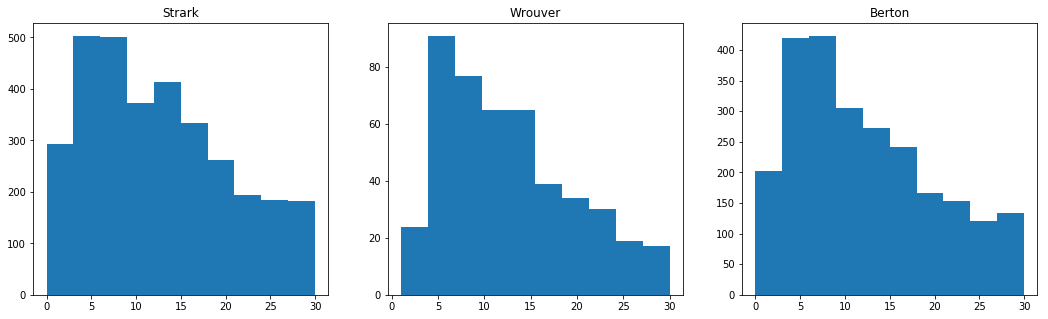

In [32]:
# Create a feature to tell the date difference between signup and first_completed.

fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(131)
ax1.hist(df[(df.city_name == 'Strark') & (df.first_completed_date.notnull())]['signup_to_completed'])
ax1.set_title('Strark')

ax2 = fig.add_subplot(132)
ax2.hist(df[(df.city_name == 'Wrouver') & (df.first_completed_date.notnull())]['signup_to_completed'])
ax2.set_title('Wrouver')

ax3 = fig.add_subplot(133)
ax3.hist(df[(df.city_name == 'Berton') & (df.first_completed_date.notnull())]['signup_to_completed'])
ax3.set_title('Berton')

plt.show()

# Section II

## **Build a statistical model to predict whether a driver that signed up will begin driving for Uber.**
  * How did the model perform? Are there any caveats? How can Uber use your model to improve our product?

### Model building

We built a model to predict whether a driver who signed up will finish his first drive within 30 days. There is a big assumption or caveat here as we did not care about whether the drive finish his first drive after 30 days of signup. We did not treat differently between drivers who make their first drive in the first week of signup or in the fourth week of their signup. 

Both LogisticRegression and RandomForestClassifier are tried. Choose LogisticRegression as our model here, as it outputs probabilities directly and easy to see how each of the features affects whether the driver will finish a first drive or not. 

First we tried a base model with features in **features_base** to get a baseline. Then we tried to improve the model by adding features like **is_weekend**, **signup_to_bgc**, **bgc_to_added** and subtracting features like **'Organic'** to improve model. 

Cross validation and hyperparameters tuning are used during the model building process. We choose F1-score as our metric to improve our model prediction as we do not care about True Negative but we care about False Positive and False Negative predictions. After model building, we can also fine tune the threshold to improve F1-score. For the best model, we have F1 score 0.801 at threshold of 0.433 with precision 0.765 and recall 0.841.

From the model output, we noticed **has_vehicle**, and **Referral** are the top three factors to affect probabilities to finish a first drive positively, while **signup_to_added**, **bgc_to_added**, and **signup_to_added** are the top three factors that affect probabilities to finish a first drive negatively. In other words, the drivers who signed up via Referral are more likely to finish a first drive. Drivers who had **bgc** are more likely to have finished first drive and who had added vehicle are more likely to finish first drive. On the other hand, the longer the drivers take to finish **bgc** after signup, the least likely the drivers will finish a first drive. The longer the drivers take to add vehicle after signup, the least likely the drivers will finish a first drive. The longer the drivers take to add vehicle after having **bgc**, the least likely the drivers will finish a first drive.

#### Remark:

  * Uber can focus more on Referral driver signup and promote it through Marketing and Campaign. 
  * Uber can remind drivers who signed up to have their **bgc** and add their vehicle.
  * Uber can target more on Mac users when doing their marketing and campaign.

### Logistic Regression

In [33]:
df_model_saved = df_model.copy(deep=True)

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing

features_base = features_less

df_model = df_model_saved[['label'] + features_base]
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df_model)
df_model_norm = pd.DataFrame(np_scaled, columns=['label'] + features_base)

df_model_norm['label'] = df_model_norm['label'].map(lambda x: 1 if x else -1)
train, validation = train_test_split(df_model_norm, test_size=0.2)
validation.reset_index(inplace=True)

model = LogisticRegressionCV(
    Cs=list(np.power(10.0, np.arange(-10, 10))), 
    penalty='l2', # 'l1', 'l2' 
    scoring='roc_auc',  # 'accuracy', 'roc_auc', 'neg_log_loss'
    cv=5, 
    random_state=777, 
    max_iter=10000, 
    fit_intercept=True, 
    solver='newton-cg',  # 'newton-cg', ‘lbfgs’, ‘sag’; ‘liblinear’
    tol=10
)
model_fit = model.fit(train[features_base], train['label'])
feature_importance = np.std(train[features_base], 0) * model_fit.coef_[0]

# The first column is the probability that the entry has the -1 label 
# and the second column is the probability that the entry has the +1 label.
prediction = pd.DataFrame(model_fit.predict_proba(validation[features_base]), columns=['NotCompleted', 'Completed'])
print('For all market, accuracy %.3f'%(model_fit.score(validation[features_base], validation['label'])))

df_check = validation[['label']].join(prediction)

i_m, F1 = 0, 0
precision, recall = 0, 0
for i in [j / 30 for j in range(1,21)]:
    Y_true = df_check['label']
    Y_predict = df_check['Completed'].map(lambda x: 1 if x > i else -1)
    f = metrics.f1_score(Y_true, Y_predict)
    p = metrics.precision_score(Y_true, Y_predict)
    r = metrics.recall_score(Y_true, Y_predict)
    if f > F1:
        i_m, F1 = i, f
        precision, recall = p, r
print('Maximum F1 score is %.3f at %.3f with precision %.3f and recall %.3f.'%(F1, i_m, precision, recall))

For all market, accuracy 0.939
Maximum F1 score is 0.763 at 0.400 with precision 0.702 and recall 0.836.


### Feature coefficients

In [35]:
df_coef = {}
df_coef['features'] = features_base
df_coef['coef'] = model_fit.coef_[0]
df_tt = pd.DataFrame(df_coef)
df_tt.sort_values(by=['coef'], ascending=False, inplace=True)
print(df_tt[['features', 'coef']])

           features      coef
12      has_vehicle  1.368974
2               mac  0.950531
4           windows  0.865934
3             other  0.727426
6          Referral  0.537435
1               ios  0.486457
0           android  0.395368
13       is_weekend  0.057139
5              Paid -0.108220
11          has_bgc -0.376318
7           vehicle -0.506796
10     bgc_to_added -0.892023
8     signup_to_bgc -1.480252
9   signup_to_added -4.205572


### Feature importance

In [36]:
df_t = pd.DataFrame(feature_importance, columns=['Importance'])
df_t = df_t.reset_index().rename(columns={'index':'Feature'})
df_t.sort_values(by=['Importance'], ascending=False, inplace=True)
print(df_t)

            Feature  Importance
12      has_vehicle    0.562029
2               mac    0.292480
4           windows    0.285028
6          Referral    0.248493
1               ios    0.223119
3             other    0.182359
0           android    0.176132
13       is_weekend    0.028087
5              Paid   -0.053811
7           vehicle   -0.161942
10     bgc_to_added   -0.163713
11          has_bgc   -0.186141
8     signup_to_bgc   -0.614092
9   signup_to_added   -1.105200


### Try RandomForestClassifier

In [37]:
# Try RandomForestClassifier
if False:
    from sklearn.model_selection import GridSearchCV

    df_model_saved = df_model.copy(deep=True)
    features_base = features

    df_model = df_model_saved[['label'] + features_base]
    min_max_scaler = preprocessing.MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(df_model)
    df_model_norm = pd.DataFrame(np_scaled, columns=['label'] + features_base)

    df_model_norm['label'] = df_model_norm['label'].map(lambda x: 1 if x else -1)
    train, validation = train_test_split(df_model_norm, test_size=0.2)
    validation.reset_index(inplace=True)

    model = RandomForestClassifier(n_jobs=-1)
    parameters = {
        "n_estimators" : [20, 50, 100, 200, 300],
        "max_depth" : [4, 8, 16, 24, 32],
        "min_samples_leaf" : [1, 2, 4, 8, 16],
        "max_features":['sqrt', 'auto'],
        "criterion":['gini', 'entropy'],
        "bootstrap": [True, False]
         }
    model_cv = GridSearchCV(estimator=model, param_grid=parameters, cv= 8)
    model_cv.fit(train[features_base], train['label'])
    print(model_cv.best_params_)

In [38]:
if False: 
    model = RandomForestClassifier(n_jobs=-1, max_features='sqrt', 
                                   max_depth=16, min_samples_leaf=8, n_estimators=50)
    model.fit(train[features_base], train['label'])

    df_coef['features'] = features_base
    df_coef['importance'] = model.feature_importances_.tolist()
    df_rf = pd.DataFrame(df_coef)
    df_rf.sort_values(by=['importance'], ascending=False, inplace=True)
    print(df_rf[['features', 'importance']])

# Section III

## **Build a model to forecast the number of new drivers we expect to start every week.**
  * How would you validate a model like this? What other information would you use if you had access to all of Uber's data?

### Forecast number of new drivers to start every week

In **Section II**, we have built a model to predict whether a new signup will start driving in the next 30 days. If we want to predict new drivers to start every week, we can build five similar models for drivers who signed up in different weeks and predict whether the driver will finish his first drive in the first week, in the second week, in the third week, in the fourth weekend and in the fifth week. 

If we want to predict new drivers to start in week 7/22/2018 - 7/28/2018, we can use the five models to predict total new drivers to start in week 7/22/2018 - 7/28/2018 and then add them up to get the expected number of new drivers to start this week.
  * model 1 predicts whether drivers who signed up during 7/15/2018 - 7/21/2018 will finish first drive in 7/22/2018 - 7/28/2018.
  * model 2 predicts whether drivers who signed up during 7/8/2018 - 7/14/2018 will finish first drive in 7/22/2018 - 7/28/2018.
  * model 3 predicts whether drivers who signed up during 7/1/2018 - 7/7/2018 will finish first drive in 7/22/2018 - 7/28/2018.
  * model 4 predicts whether drivers who signed up during 6/24/2018 - 6/30/2018 will finish first drive in 7/22/2018 - 7/28/2018.
  * model 5 predicts whether drivers who signed up during 6/17/2018 - 6/23/2018 will finish first drive in 7/22/2018 - 7/28/2018.
  * TotalNewDrivers = NumberModel1 + NumberModel2 + NumberModel3 + NumberModel4 + NumberModel5
  
For validation of such a model, we can use historical data and split them as training data, validation data and test data. Test data is the pretended 'future unseen data', which is after training data and validation data. Training data and validation data are the dataset for cross validation during model building. Training data and validation data are dataset from the same time period with a random splitting.   
   
Some other data will be useful for building a better model and making a better prediction. 

  * The first will be driver demographic data. Including these data will improve our model performance. 
  * The second will be marketing and campaign data. Marketing and campaign will affect new drivers to start every week. 
  * The third will be competitor data which will also affect new drivers. 
  
I would like to explore the influence of these factors/data to new drivers. 

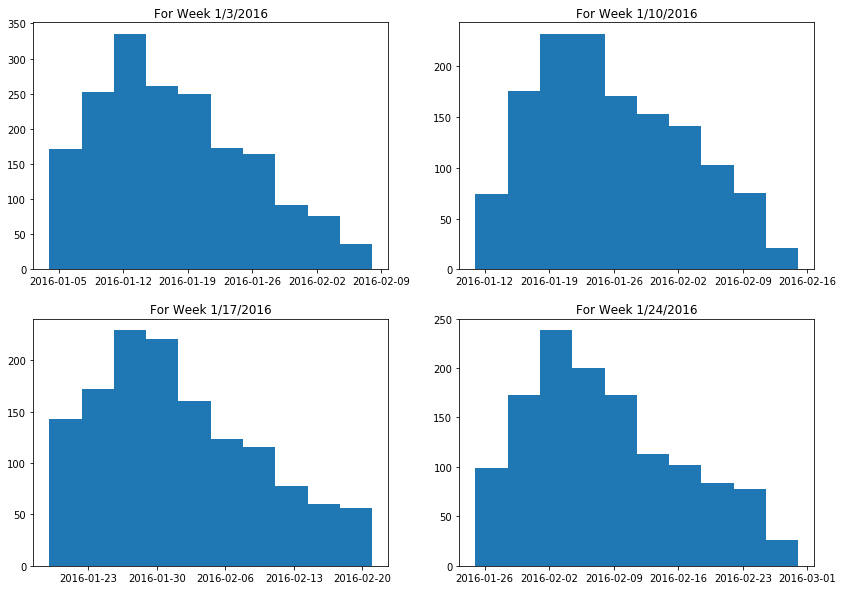

In [39]:
# Group drivers signed in one week as a cohort group
# View the distribution of their first ride by date
# All these different cohort groups follow very similar pattern 
# in the sense how much percent finish first drive in the first week, or in the second week, ...
# This justifies our approach to build models to predict whether drivers signup will 
# finish their first drive in first week, or in second week, ... 

fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(221)
ax1.hist(df[(df.signup_date >= '2016-01-03T00:00:00.000000000') 
            & (df.first_completed_date.notnull())
           & (df.signup_date < '2016-01-10T00:00:00.000000000')].first_completed_date)
ax1.set_title('For Week 1/3/2016')

ax2 = fig.add_subplot(222)
ax2.hist(df[(df.signup_date >= '2016-01-10T00:00:00.000000000') 
            & (df.first_completed_date.notnull())
           & (df.signup_date < '2016-01-17T00:00:00.000000000')].first_completed_date)
ax2.set_title('For Week 1/10/2016')

ax3 = fig.add_subplot(223)
ax3.hist(df[(df.signup_date >= '2016-01-17T00:00:00.000000000') 
            & (df.first_completed_date.notnull())
           & (df.signup_date < '2016-01-24T00:00:00.000000000')].first_completed_date)
ax3.set_title('For Week 1/17/2016')

ax4 = fig.add_subplot(224)
ax4.hist(df[(df.signup_date >= '2016-01-24T00:00:00.000000000') 
            & (df.first_completed_date.notnull())
           & (df.signup_date < '2016-01-31T00:00:00.000000000')].first_completed_date)
ax4.set_title('For Week 1/24/2016')

plt.show()

### Thank you very much and have a great day!